After running your Pylearn2 models, it's probably not best to compare them on the score they get on the validation set, as that is used in the training process; so could be the victim of overfitting. It would be better to run the model over the _test_ set, which is supposed to be a holdout set used to compare models. We could rerun all our models with a monitor on this value, but for models we've already run, it might be more useful to be able to pull out this value for _just_ that pickle.

This is likely to be wasted effort, because it seems like the kind of thing that should already exist in Pylearn2. Unfortunately, since I can't find it and it seems fairly simple to implement I'm just going to go ahead and write it.

Hopefully, this will also help us figure out what's going wrong with some submissions, that turn out to be incredibly bad; for example, those using augmentation.

In [1]:
import pylearn2.utils
import pylearn2.config
import theano
import neukrill_net.dense_dataset
import neukrill_net.utils
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import holoviews as hl
%load_ext holoviews.ipython

Using gpu device 0: Tesla K40c
:0: FutureWarning: IPython widgets are experimental and may change in the future.


Welcome to the HoloViews IPython extension! (http://ioam.github.io/holoviews/)
Available magics: %compositor, %opts, %params, %view, %%labels, %%opts, %%view


Loading data and model
========

Initialise, loading the settings and the test dataset we're going to be using:

In [2]:
cd ..

/afs/inf.ed.ac.uk/user/s08/s0805516/repos/neukrill-net-work


In [153]:
settings = neukrill_net.utils.Settings("settings.json")
run_settings = neukrill_net.utils.load_run_settings(
    "run_settings/alexnet_based_norm_global.json", settings, force=True)

In [154]:
%%time
# loading the model
model = pylearn2.utils.serial.load(run_settings['pickle abspath'])

CPU times: user 5.75 s, sys: 125 ms, total: 5.88 s
Wall time: 5.98 s


In [155]:
reload(neukrill_net.dense_dataset)

<module 'neukrill_net.dense_dataset' from '/afs/inf.ed.ac.uk/user/s08/s0805516/repos/neukrill-net-tools/neukrill_net/dense_dataset.pyc'>

In [156]:
%%time
# loading the data
dataset = neukrill_net.dense_dataset.DensePNGDataset(settings_path=run_settings['settings_path'],
                                            run_settings=run_settings['run_settings_path'],
                                                     train_or_predict='train',
                                                     training_set_mode='test', force=True)

CPU times: user 5.18 s, sys: 270 ms, total: 5.45 s
Wall time: 6.15 s


Setting up forward pass
========

Now we've loaded the data and the model we're going to set up a forward pass through the data in the same way we do it in the `test.py` script: pick a batch size, compile a Theano function and then iterate over the whole dataset in batches, filling an array of predictions.

In [157]:
# find allowed batch size over 1000 (want big batches)
# (Theano has to have fixed batch size and we don't want leftover)
batch_size=1000
while dataset.X.shape[0]%batch_size != 0:
    batch_size += 1

In [158]:
n_batches = int(dataset.X.shape[0]/batch_size)

In [159]:
%%time
# set this batch size
model.set_batch_size(batch_size)
# compile Theano function
X = model.get_input_space().make_batch_theano()
Y = model.fprop(X)
f = theano.function([X],Y)

CPU times: user 1.15 s, sys: 18 ms, total: 1.17 s
Wall time: 1.16 s


Compute probabilities
========

In [160]:
%%time
y = np.zeros((dataset.X.shape[0],len(settings.classes)))
for i in xrange(n_batches-1):
    print("Batch {0} of {1}".format(i+1,n_batches))
    x_arg = dataset.X[i*batch_size:(i+1)*batch_size,:]
    if X.ndim > 2:
        x_arg = dataset.get_topological_view(x_arg)
    y[i*batch_size:(i+1)*batch_size,:] = (f(x_arg.astype(X.dtype).T))

CPU times: user 1e+03 µs, sys: 0 ns, total: 1e+03 µs
Wall time: 945 µs


Wait, why does `test.py` only iterate up to the second last batch? Isn't that going to leave a bunch of predictions as zero? Looking at tresults:

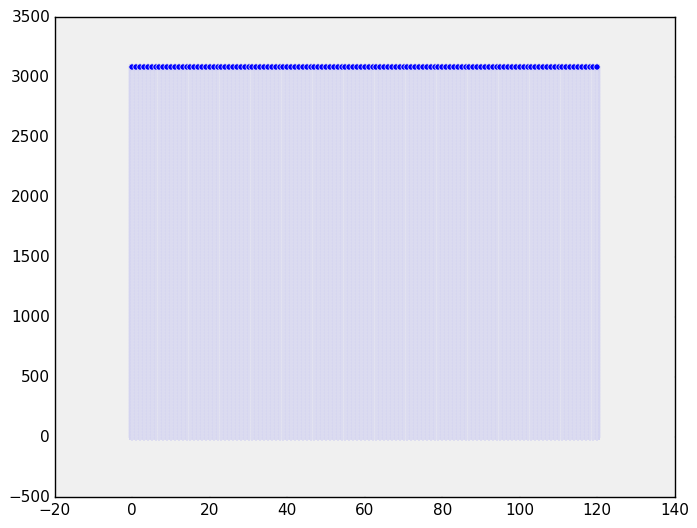

In [161]:
plt.scatter(np.where(y == 0)[1],np.where(y==0)[0])

Fixing this, should get much better results, but the real question is _how are we getting a good score at all_ in this case? The answer could be that I recently changed the code to iterate over the batches in a different way (I thought it was doing the same thing) but _we don't actually have to check that, do we?_.

In [162]:
%%time
y = np.zeros((dataset.X.shape[0],len(settings.classes)))
for i in xrange(n_batches):
    print("Batch {0} of {1}".format(i+1,n_batches))
    x_arg = dataset.X[i*batch_size:(i+1)*batch_size,:]
    if X.ndim > 2:
        x_arg = dataset.get_topological_view(x_arg)
    y[i*batch_size:(i+1)*batch_size,:] = (f(x_arg.astype(X.dtype).T))

Batch 1 of 1
CPU times: user 725 ms, sys: 696 ms, total: 1.42 s
Wall time: 1.42 s


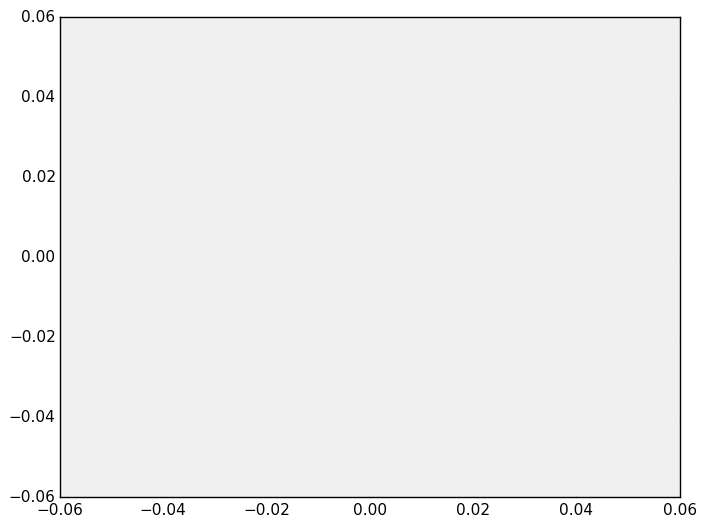

In [163]:
plt.scatter(np.where(y == 0)[1],np.where(y==0)[0])

Of course, it's strange that there are _any zeros at all_. Hopefully they'll go away when we start averaging.

Score before averaging
========

We can score the model before averaging by just using the class labels as they were going to be used for training. Using Sklearn's utility for calculating log_loss:

In [164]:
import sklearn.metrics

In [165]:
sklearn.metrics.log_loss(dataset.y,y)

1.9629059484268205

Score after averaging
========

In `test.py` we take the least intelligent approach to dealing with averaging over the different augmented versions. Basically, we just assume that whatever the augmentation factor is, the labels must repeat over that step size, so we can just collapse those into a single vector of probabilities.

First, we should check that assumption:

In [166]:
# augmentation factor
af = 1

In [167]:
for low,high in zip(range(0,dataset.y.shape[0],af),range(af,dataset.y.shape[0]+af,af)):
    first = dataset.y[low][0]
    if any(first != i for i in dataset.y[low:high].ravel()):
        print("Labels do not match at:", (low,high))
        break

In [168]:
y_collapsed = np.zeros((int(dataset.X.shape[0]/af), len(settings.classes))) 
for i,(low,high) in enumerate(zip(range(0,dataset.y.shape[0],af),
                                  range(af,dataset.y.shape[0]+af,af))):
    y_collapsed[i,:] = np.mean(y[low:high,:], axis=0)

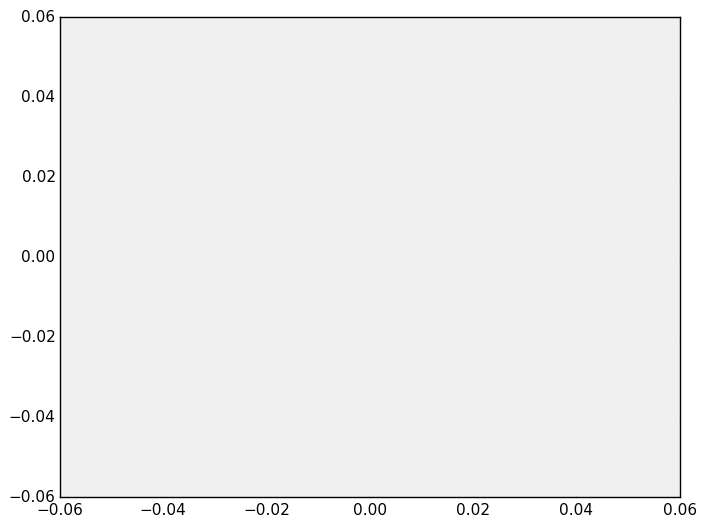

In [169]:
plt.scatter(np.where(y_collapsed == 0)[1],np.where(y_collapsed == 0)[0])

There are no zeros in there now!

In [170]:
labels_collapsed = dataset.y[range(0,dataset.y.shape[0],af)]

In [171]:
labels_collapsed.shape

(3089, 1)

In [172]:
sklearn.metrics.log_loss(labels_collapsed,y_collapsed)

1.9629059484268205

That's pretty much exactly what we got on the leaderboard.